# Introduction

This notebook serves as a template for conducting a simple differential expression analysis for RNA-Seq using the DESeq2 package. Before using this template, you must have completed the bioinformatics pipeline (from fastq to count files). For each sample, you need to have a "count" file generated by htseq-count. 

## Count file location

The template assumes that the count files are located in a single directory. Here we set the directory and then check to make sure that the files you need are physically located in the specified directory.

In [1]:
cntdir<-"~/work/share/2016_results/all_counts/"
list.files(cntdir)

[1] "10Dbeta.csv"    "11Bbeta.csv"    "12Fbeta.csv"    "13Abeta.csv"   
 [5] "14Ebeta.csv"    "15Cgamma.csv"   "16Dgamma.csv"   "17Egamma.csv"  
 [9] "18Cgamma.csv"   "19Agamma.csv"   "1Aalpha.csv"    "20Bgamma.csv"  
[13] "21Fgamma.csv"   "22Ddelta.csv"   "23Fdelta.csv"   "24Adelta.csv"  
[17] "25Bdelta.csv"   "26Cdelta.csv"   "27Ddelta.csv"   "29Eepsilon.csv"
[21] "2Balpha.csv"    "30Fepsilon.csv" "31Aepsilon.csv" "32Bepsilon.csv"
[25] "33Cepsilon.csv" "34Depsilon.csv" "35Eepsilon.csv" "3Calpha.csv"   
[29] "4Dalpha.csv"    "5Ealpha.csv"    "6Aalpha.csv"    "8Bbeta.csv"    
[33] "9Cbeta.csv"

# Load packages

Load DESeq2, dplyr, qvalue packages. The dplyr package is used for manipulating the phenotype data data frame and the qvalue packages is used for calculating FDR adjusted P-values. 

In [2]:
library(DESeq2)
library(dplyr)
library(qvalue)

options(wdith=200)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit


Attaching package: ‘S4Vectors’

The following objects are masked from ‘package:base’:

    c

This template has been tested under R version 3.3.1 and DESeq2 version 1.12.3. Use sessionInfo() to confirm that you are using these version. The template may work with other versions as well

In [ ]:
sessionInfo()

# Create phenotype data frame

To proceed, you need to create a phenotype data frame whose first column contains the sample names and whose second column contains the file names. The remaining columns should contain the experimental factors and covariates that you need for your analysis. For this template, we will name the data frame phdata.

In [3]:
# Specify the manifest file name
manidir<-"/home/jovyan/work/Materials/ComputationBootCampNotebooks/Wk5_Day3/info"
manifile<-file.path(manidir,"final_meta_data_for_deseq.csv")
tools::md5sum(manifile)
# Read in the csv file
manidat<-read.csv(manifile)
# Check size
dim(manidat)
# Have a peek
head(manidat)

/home/jovyan/work/Materials/ComputationBootCampNotebooks/Wk5_Day3/info/final_meta_data_for_deseq.csv 
                                                                  "b118c119060c1809c4827c4453d567b5"

[1] 33 14

SampleFile Group SampleNum SampleClass Replicate bio_rep tech_rep ng_ul
1 1Aalpha.csv alpha         1           A         1       1        a 233.0
2 2Balpha.csv alpha         2           B         1       1        a 293.6
3 3Calpha.csv alpha         3           C         1       1        a 222.1
4 4Dalpha.csv alpha         4           D         1       1        a 225.7
5 5Ealpha.csv alpha         5           E         1       1        a 205.6
6 6Aalpha.csv alpha         6           A         5       2        b 139.5
          Description  pH       treatment Sample_ID I7_Index_ID    index
1 pH6-vehicle control pH6 vehicle control         1       P1-A1 TTACCGAC
2 pH7-vehicle control pH7 vehicle control         2       P2-A2 AGTGACCT
3           pH6-DU011 pH6           DU011         3       P3-A3 TCGGATTC
4           pH7-DU011 pH7           DU011         4       P4-A4 CAAGGTAC
5      pH6-Salicylate pH6      Salicylate         5       P5-A5 TCCTCATG
6 pH6-vehicle control pH6 vehicle control         6       P6-A6 GTCAGTCA

In [4]:
### Create phdata data frame
phdata<-dplyr::transmute(manidat,
                        sampleid=paste(SampleNum,Group,treatment,pH,sep="-"),
                        fname=SampleFile,
                        trt=as.factor(treatment),
                        ph=as.factor(pH),
                        bio_rep,
                        tech_rep)
phdata
### This saves the phdata data frame to a file. To retrieve this
### data frame in another notebook do attach("fullphdata.RData")
save(phdata,file="fullphdata.RData")

sampleid          fname
1                  1-alpha-vehicle control-pH6    1Aalpha.csv
2                  2-alpha-vehicle control-pH7    2Balpha.csv
3                            3-alpha-DU011-pH6    3Calpha.csv
4                            4-alpha-DU011-pH7    4Dalpha.csv
5                       5-alpha-Salicylate-pH6    5Ealpha.csv
6                  6-alpha-vehicle control-pH6    6Aalpha.csv
7                   8-beta-vehicle control-pH7     8Bbeta.csv
8                             9-beta-DU011-pH6     9Cbeta.csv
9                            10-beta-DU011-pH7    10Dbeta.csv
10                 11-beta-vehicle control-pH7    11Bbeta.csv
11                      12-beta-Salicylate-pH7    12Fbeta.csv
12                 13-beta-vehicle control-pH6    13Abeta.csv
13                      14-beta-Salicylate-pH6    14Ebeta.csv
14                          15-gamma-DU011-pH6   15Cgamma.csv
15                          16-gamma-DU011-pH7   16Dgamma.csv
16                     17-gamma-Salicylate-pH6   17Egamma.csv
17                          18-gamma-DU011-pH6   18Cgamma.csv
18                19-gamma-vehicle control-pH6   19Agamma.csv
19                20-gamma-vehicle control-pH7   20Bgamma.csv
20                     21-gamma-Salicylate-pH7   21Fgamma.csv
21                          22-delta-DU011-pH7   22Ddelta.csv
22                     23-delta-Salicylate-pH7   23Fdelta.csv
23                24-delta-vehicle control-pH6   24Adelta.csv
24                25-delta-vehicle control-pH7   25Bdelta.csv
25                          26-delta-DU011-pH6   26Cdelta.csv
26                          27-delta-DU011-pH7   27Ddelta.csv
27                   29-epsilon-Salicylate-pH6 29Eepsilon.csv
28                   30-epsilon-Salicylate-pH7 30Fepsilon.csv
29              31-epsilon-vehicle control-pH6 31Aepsilon.csv
30              32-epsilon-vehicle control-pH7 32Bepsilon.csv
31                        33-epsilon-DU011-pH6 33Cepsilon.csv
32 34-epsilon-DU011_and_Salicylate-pH7_and_pH6 34Depsilon.csv
33 35-epsilon-DU011_and_Salicylate-pH7_and_pH6 35Eepsilon.csv
                    trt          ph bio_rep tech_rep
1       vehicle control         pH6       1        a
2       vehicle control         pH7       1        a
3                 DU011         pH6       1        a
4                 DU011         pH7       1        a
5            Salicylate         pH6       1        a
6       vehicle control         pH6       2        b
7       vehicle control         pH7       2        a
8                 DU011         pH6       2        b
9                 DU011         pH7       2        a
10      vehicle control         pH7       3        a
11           Salicylate         pH7       2        a
12      vehicle control         pH6       3        a
13           Salicylate         pH6       2        b
14                DU011         pH6       3        a
15                DU011         pH7       3        a
16           Salicylate         pH6       3        a
17                DU011         pH6       1        a
18      vehicle control         pH6       1        a
19      vehicle control         pH7       1        a
20           Salicylate         pH7       3        a
21                DU011         pH7       1        a
22           Salicylate         pH7       1        a
23      vehicle control         pH6       2        b
24      vehicle control         pH7       2        b
25                DU011         pH6       2        b
26                DU011         pH7       2        b
27           Salicylate         pH6       2        b
28           Salicylate         pH7       2        a
29      vehicle control         pH6       3        b
30      vehicle control         pH7       3        b
31                DU011         pH6       3        b
32 DU011_and_Salicylate pH7_and_pH6       3        b
33 DU011_and_Salicylate pH7_and_pH6       3        b

# Create the DESeq2 data object

Be sure to set the appropriate design (e.g., ~trt or ~ph+trt etc)

In [107]:
###n Subset phdata based on the samples you need for your analysis
### IMPORTANT: Sample exclusion should NOT be taken lightly.
### Filtered dataframe for analyzing treatment effect withing pH7
###phdata0<-filter(phdata,
###               trt%in%c("vehicle control","DU011"),
###              ph=="pH7",
###               !sampleid%in%c("25-delta-vehicle control-pH7","8-beta-vehicle control-pH7"))
###
### Filtered dataframe for analyzing treatment effect using pH
### as additive effect
# phdata0<-filter(phdata,
#                 trt%in%c("vehicle control","DU011"),
#                !fname%in%c("1Aalpha.csv","2Balpha.csv"))
phdata0<-filter(phdata,
                 trt%in%c("vehicle control","Salicylate","DU011"),
                !sampleid%in%c("34-epsilon-DU011_and_Salicylate-pH7_and_pH6","35-epsilon-DU011_and_Salicylate-pH7_and_pH6"))


phdata0

sampleid          fname             trt  ph bio_rep
1     1-alpha-vehicle control-pH6    1Aalpha.csv vehicle control pH6       1
2     2-alpha-vehicle control-pH7    2Balpha.csv vehicle control pH7       1
3               3-alpha-DU011-pH6    3Calpha.csv           DU011 pH6       1
4               4-alpha-DU011-pH7    4Dalpha.csv           DU011 pH7       1
5          5-alpha-Salicylate-pH6    5Ealpha.csv      Salicylate pH6       1
6     6-alpha-vehicle control-pH6    6Aalpha.csv vehicle control pH6       2
7      8-beta-vehicle control-pH7     8Bbeta.csv vehicle control pH7       2
8                9-beta-DU011-pH6     9Cbeta.csv           DU011 pH6       2
9               10-beta-DU011-pH7    10Dbeta.csv           DU011 pH7       2
10    11-beta-vehicle control-pH7    11Bbeta.csv vehicle control pH7       3
11         12-beta-Salicylate-pH7    12Fbeta.csv      Salicylate pH7       2
12    13-beta-vehicle control-pH6    13Abeta.csv vehicle control pH6       3
13         14-beta-Salicylate-pH6    14Ebeta.csv      Salicylate pH6       2
14             15-gamma-DU011-pH6   15Cgamma.csv           DU011 pH6       3
15             16-gamma-DU011-pH7   16Dgamma.csv           DU011 pH7       3
16        17-gamma-Salicylate-pH6   17Egamma.csv      Salicylate pH6       3
17             18-gamma-DU011-pH6   18Cgamma.csv           DU011 pH6       1
18   19-gamma-vehicle control-pH6   19Agamma.csv vehicle control pH6       1
19   20-gamma-vehicle control-pH7   20Bgamma.csv vehicle control pH7       1
20        21-gamma-Salicylate-pH7   21Fgamma.csv      Salicylate pH7       3
21             22-delta-DU011-pH7   22Ddelta.csv           DU011 pH7       1
22        23-delta-Salicylate-pH7   23Fdelta.csv      Salicylate pH7       1
23   24-delta-vehicle control-pH6   24Adelta.csv vehicle control pH6       2
24   25-delta-vehicle control-pH7   25Bdelta.csv vehicle control pH7       2
25             26-delta-DU011-pH6   26Cdelta.csv           DU011 pH6       2
26             27-delta-DU011-pH7   27Ddelta.csv           DU011 pH7       2
27      29-epsilon-Salicylate-pH6 29Eepsilon.csv      Salicylate pH6       2
28      30-epsilon-Salicylate-pH7 30Fepsilon.csv      Salicylate pH7       2
29 31-epsilon-vehicle control-pH6 31Aepsilon.csv vehicle control pH6       3
30 32-epsilon-vehicle control-pH7 32Bepsilon.csv vehicle control pH7       3
31           33-epsilon-DU011-pH6 33Cepsilon.csv           DU011 pH6       3
   tech_rep
1         a
2         a
3         a
4         a
5         a
6         b
7         a
8         b
9         a
10        a
11        a
12        a
13        b
14        a
15        a
16        a
17        a
18        a
19        a
20        a
21        a
22        a
23        b
24        b
25        b
26        b
27        b
28        a
29        b
30        b
31        b

In [108]:
### Treatment effect without adjusting for pH: design~trt
# dds<-DESeqDataSetFromHTSeqCount(sampleTable=phdata0,
#                                 design=~ trt,
#                                 directory = cntdir)

### Treatment effect adjusting for pH: design~ph+trt
dds<-DESeqDataSetFromHTSeqCount(sampleTable=phdata0,
                                 design=~ ph+trt,
                                 directory = cntdir)

### Treatment by pH level interaction with respect to abdundance
### Add a vector with all combinations of trt and pH
###dds$trtpH<-factor(paste0(phdata0$trt,phdata0$ph))
### Update design
###design(dds)<-~trtpH

###dds@colData
# trtPH

factor levels were dropped which had no samples


In [109]:
head(counts(dds))

1-alpha-vehicle control-pH6 2-alpha-vehicle control-pH7
USA300HOU_0001 "57"                        "103"                      
USA300HOU_0002 "89"                        "124"                      
USA300HOU_0003 "20"                        "24"                       
USA300HOU_0004 "96"                        "97"                       
USA300HOU_0005 "169"                       "149"                      
USA300HOU_0006 "264"                       "218"                      
               3-alpha-DU011-pH6 4-alpha-DU011-pH7 5-alpha-Salicylate-pH6
USA300HOU_0001 "11"              "33"              "51"                  
USA300HOU_0002 "25"              "61"              "76"                  
USA300HOU_0003 "2"               "11"              "31"                  
USA300HOU_0004 "17"              "72"              "92"                  
USA300HOU_0005 "20"              "106"             "179"                 
USA300HOU_0006 "53"              "178"             "328"                 
               6-alpha-vehicle control-pH6 8-beta-vehicle control-pH7
USA300HOU_0001 "126"                       "166"                     
USA300HOU_0002 "129"                       "202"                     
USA300HOU_0003 "23"                        "23"                      
USA300HOU_0004 "139"                       "121"                     
USA300HOU_0005 "356"                       "366"                     
USA300HOU_0006 "532"                       "591"                     
               9-beta-DU011-pH6 10-beta-DU011-pH7 11-beta-vehicle control-pH7
USA300HOU_0001 "8"              "28"              "60"                       
USA300HOU_0002 "9"              "57"              "121"                      
USA300HOU_0003 "3"              "11"              "15"                       
USA300HOU_0004 "26"             "85"              "94"                       
USA300HOU_0005 "49"             "147"             "119"                      
USA300HOU_0006 "68"             "204"             "200"                      
               ⋯   23-delta-Salicylate-pH7 24-delta-vehicle control-pH6
USA300HOU_0001 "⋯" "198"                   "176"                       
USA300HOU_0002 "⋯" "272"                   "167"                       
USA300HOU_0003 "⋯" "23"                    "30"                        
USA300HOU_0004 "⋯" "166"                   "195"                       
USA300HOU_0005 "⋯" "279"                   "499"                       
USA300HOU_0006 "⋯" "455"                   "810"                       
               25-delta-vehicle control-pH7 26-delta-DU011-pH6
USA300HOU_0001 "225"                        "22"              
USA300HOU_0002 "246"                        "31"              
USA300HOU_0003 "21"                         "11"              
USA300HOU_0004 "143"                        "77"              
USA300HOU_0005 "404"                        "129"             
USA300HOU_0006 "695"                        "148"             
               27-delta-DU011-pH7 29-epsilon-Salicylate-pH6
USA300HOU_0001 "59"               "142"                    
USA300HOU_0002 "75"               "157"                    
USA300HOU_0003 "4"                "14"                     
USA300HOU_0004 "93"               "125"                    
USA300HOU_0005 "160"              "248"                    
USA300HOU_0006 "250"              "487"                    
               30-epsilon-Salicylate-pH7 31-epsilon-vehicle control-pH6
USA300HOU_0001 "114"                     "35"                          
USA300HOU_0002 "175"                     "66"                          
USA300HOU_0003 "18"                      "5"                           
USA300HOU_0004 "107"                     "91"                          
USA300HOU_0005 "245"                     "82"                          
USA300HOU_0006 "367"                     "198"                         
               32-epsilon-vehicle control-pH7 33-epsilon-DU011-pH6
USA300HOU_0001 "39"         

# Estimate Size Factors and Dispersion Parameters

You recall that DESeq requires that  we have estimates for sample specific size factors and gene specific dispersion factors. More specifically, recall that DESeq models the count $K_{ij}$ (gene $i$, sample $j$) as negative binomial with mean $\mu_{ij}$ and dispersion parameter $\alpha_i$. Here $\mu_{ij}=s_j q_{ij}$ where $\log_2(q_{ij}) = \beta_{0i} + \beta_{1i} z_j$. Here $s_j$ is the sample $j$ specific size factor.

## Size Factors

We begin by estimating the size factors $s_1,\ldots,s_n$:

In [110]:
dds <- estimateSizeFactors(dds)
sizeFactors(dds)
summary(sizeFactors(dds))

1-alpha-vehicle control-pH6    2-alpha-vehicle control-pH7 
                    1.10973595                     1.52575887 
             3-alpha-DU011-pH6              4-alpha-DU011-pH7 
                    0.33331526                     1.00383642 
        5-alpha-Salicylate-pH6    6-alpha-vehicle control-pH6 
                    1.32803896                     1.38708460 
    8-beta-vehicle control-pH7               9-beta-DU011-pH6 
                    2.85026317                     0.16846502 
             10-beta-DU011-pH7    11-beta-vehicle control-pH7 
                    0.98239166                     1.38708460 
        12-beta-Salicylate-pH7    13-beta-vehicle control-pH6 
                    1.22631900                     0.60692682 
        14-beta-Salicylate-pH6             15-gamma-DU011-pH6 
                    2.43752763                     0.26412256 
            16-gamma-DU011-pH7        17-gamma-Salicylate-pH6 
                    0.72855605                     1.15148888 
            18-gamma-DU011-pH6   19-gamma-vehicle control-pH6 
                    0.37383715                     1.96555694 
  20-gamma-vehicle control-pH7        21-gamma-Salicylate-pH7 
                    1.15385096                     1.05966273 
            22-delta-DU011-pH7        23-delta-Salicylate-pH7 
                    1.14016693                     3.51401688 
  24-delta-vehicle control-pH6   25-delta-vehicle control-pH7 
                    2.04956166                     3.44477711 
            26-delta-DU011-pH6             27-delta-DU011-pH7 
                    0.41939544                     1.12229707 
     29-epsilon-Salicylate-pH6      30-epsilon-Salicylate-pH7 
                    2.13200041                     2.10400772 
31-epsilon-vehicle control-pH6 32-epsilon-vehicle control-pH7 
                    0.80846530                     1.38231225 
          33-epsilon-DU011-pH6 
                    0.09604608

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.09605 0.76850 1.15100 1.33100 1.74600 3.51400 

## Dispersion Parameters

Next, we get the dispersion factors $\alpha_1,\ldots,\alpha_{m}$

In [111]:
dds<-estimateDispersions(dds)

gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates


# Differential Expression Analysis

We can now conduct a differential expression analysis using the DESeq() function. Keep in mind that to get to this step, we first estimated the size factors and then the dispersion parameters.

In [112]:
design(dds)
ddsDE<-DESeq(dds)

~ph + trt

using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
fitting model and testing


We can get the results for the differential expression analysis using results()

In [113]:
myresD<-results(ddsDE,contrast=c("trt","vehicle control","DU011"))
myresS<-results(ddsDE,contrast=c("trt","vehicle control","Salicylate"))

Compare vehicle control to Du011

In [116]:
summary(myresD,alpha=0.01)


out of 2740 with nonzero total read count
adjusted p-value < 0.01
LFC > 0 (up)     : 272, 9.9% 
LFC < 0 (down)   : 184, 6.7% 
outliers [1]     : 2, 0.073% 
low counts [2]   : 371, 14% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [ ]:
Compare vehicle control to Du011

## Volcano Plot

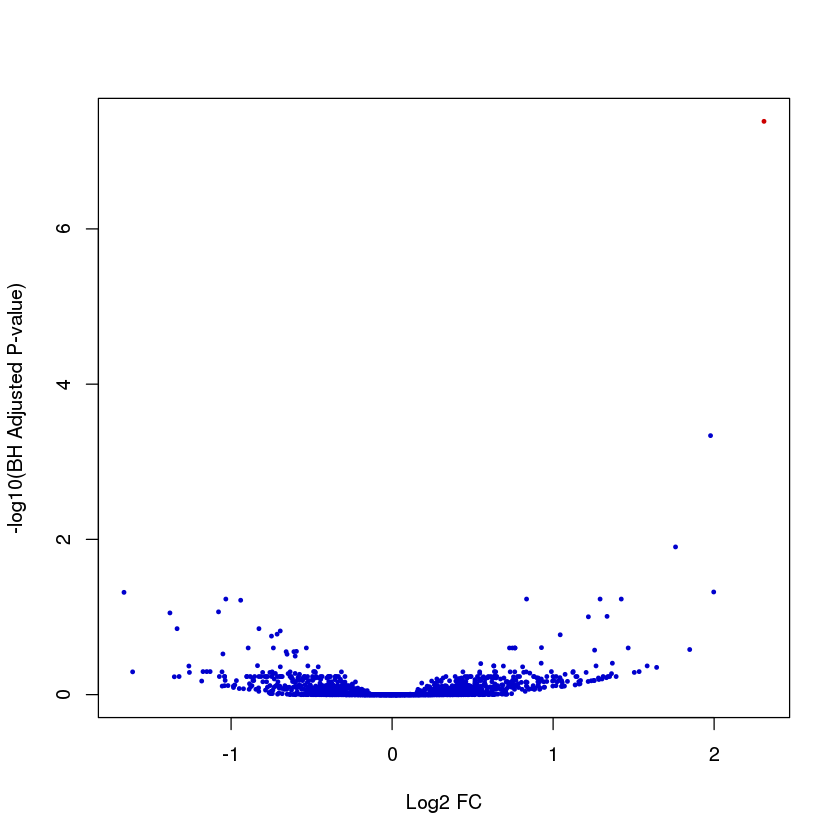

In [119]:
myres<-myresS
plot(myres$log2FoldChange,
     -log10(myres$padj),
     pch=19,cex=0.4,
     xlab="Log2 FC",
     ylab="-log10(BH Adjusted P-value)",
     col=ifelse(myres$padj<0.01&abs(myres$log2FoldChange)>2,"red3","blue3"))

## Regularized log transformation

The regularized log transform can be obtained using the rlog() function. Note that an important argument for this function is blind (TRUE by default). The default "blinds" the normalization to the design. This is very important so as to not bias the analyses (e.g. class discovery 

In [32]:
rld<-rlog(dds,blind=TRUE)
expdat<-assay(rld)
dim(expdat)

[1] 2841   23

# Cluster Analysis

## Hierarchical clustering using rlog transformation

In [ ]:
dists<-dist(t(assay(rld)))
plot(hclust(dists))

In [ ]:
## Principal Components Analysis

In [ ]:
 plotPCA(rld,intgroup="trt")

Look at one gene

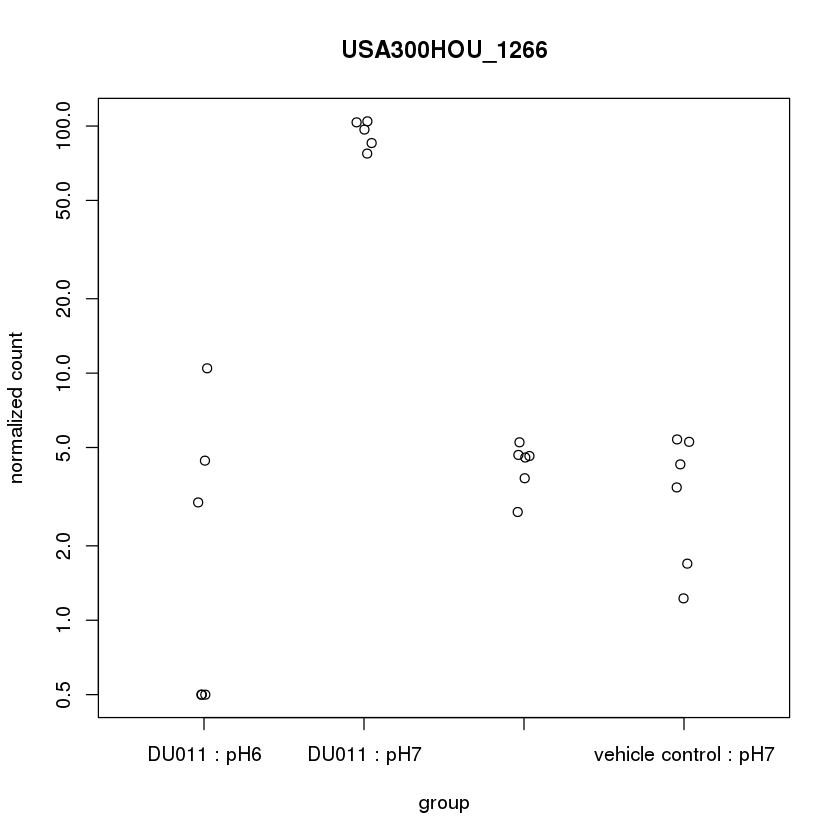

In [13]:
 plotCounts(dds, "USA300HOU_1266",intgroup=c("trt","ph"))

Sort results according to adjusted p-value

In [11]:
arrange(add_rownames(as.data.frame(myres),"geneid"),padj)

geneid           baseMean      log2FoldChange
1                USA300HOU_2310   100.968664129022    4.00209425824173
2                USA300HOU_1266   22.7090442356714   -4.81930965244256
3                USA300HOU_0207   63.0328042561833    4.07370505292028
4                USA300HOU_0801      233.110195095   -3.39569684031962
5                USA300HOU_2346   94.9964911083756   -8.17066956940766
6                USA300HOU_2347   92.1484608522064   -7.74031677229541
7                USA300HOU_1265   22.9495799231543   -6.20302079508266
8                USA300HOU_2359   27.1266969968517   -6.76213194019909
9                USA300HOU_2311   104.853400425873    4.49315260165859
10               USA300HOU_1669   291.329077853227    2.33185891701853
11               USA300HOU_0206   75.7180347384273    4.25734381061899
12    USA300HOU_pUSA10HOUMR0005    45.955793944514    2.20788671260621
13               USA300HOU_0511   57.1393338408677    3.74087641919015
14               USA300HOU_0512    64.193360582427    4.09520098835257
15               USA300HOU_1263   18.4278585152511   -7.93666680691519
16   USA300HOU_pUSA300HOUMR0004   33.0041876657314    3.62471965978032
17               USA300HOU_0474   232.795851602359   -2.77234316258838
18               USA300HOU_0008   37.2434900026277     3.7556688706025
19               USA300HOU_1674   265.652351289703    5.30678417794915
20               USA300HOU_2546   53.0731480190252   -6.70200123936545
21               USA300HOU_0475   70.5604707243971   -2.69522639965246
22               USA300HOU_0762   16.7092013528985   -2.83092999626471
23               USA300HOU_2499   67.4537922532639    2.49287565957531
24               USA300HOU_1264   12.3378093320969   -7.41360274371072
25               USA300HOU_2202   27.2404775495977   -3.49084306298837
26             USA300HOU_nc0020   168.930765779896    5.62939392009304
27               USA300HOU_2333   166.276944227055   -3.70446891133449
28               USA300HOU_0340   54.2488141129774    4.08655176176572
29               USA300HOU_2035   327.638124995607    2.80918211010197
30               USA300HOU_1722   44.2588820546948     2.0041087241702
⋮                             ⋮                  ⋮                   ⋮
2812           USA300HOU_nc0016 0.0603637850097158  -0.177554523347972
2813           USA300HOU_nc0018 0.0723526207123729 -0.0909684275532357
2814  USA300HOU_pUSA10HOUMR0003   0.29470756749638   -0.15160262815678
2815 USA300HOU_pUSA300HOUMR0005 0.0236363373513839 -0.0674742149078232
2816 USA300HOU_pUSA300HOUMR0006  0.219010637794005   0.750375357641747
2817            USA300HOU_r0002   454.774245252077   -1.07155594623297
2818            USA300HOU_r0003  0.172583737567494 -0.0559304517483578
2819            USA300HOU_r0006    460.31676585938    -1.0837074225152
2820            USA300HOU_r0008  0.281997901257671  -0.271312159797573
2821            USA300HOU_t0002  0.148951475368734  -0.499683838646633
2822            USA300HOU_t0004  0.207841163559438   0.174277918765911
2823            USA300HOU_t0006  0.261201768272506  -0.524576628468612
2824            USA300HOU_t0010   0.24676857151025  -0.889525462932506
2825            USA300HOU_t0013 0.0728001907656176  -0.106128613632851
2826            USA300HOU_t0017  0.316029844658548   0.295167637474958
2827            USA300HOU_t0018 0.0579276832154088  -0.177554523347973
2828            USA300HOU_t0020  0.287885075561071   0.523693820230619
2829            USA300HOU_t0028   0.29610140834201  -0.822905144355799
2830            USA300HOU_t0031  0.279258232015908 -0.0436150505548724
2831            USA300HOU_t0033  0.208191522598145  -0.327226064650285
2832            USA300HOU_t0043  0.212530039730948   -1.06652270874443
2833            USA300HOU_t0046  0.147691433354809   0.280857224129661
2834            USA300HOU_t0049  0.196667087898064  0.0686988244550918
2835            USA300HOU_t0050  0.133552870068352  -0.164588738168721
2836            USA300HOU_t0052  0.14784472109886

In [ ]:
sessionInfo()

Get the number of reads mapped to each sample

In [ ]:
colSums(counts(dds))

In [ ]:
### Show the results from the two-factor ph+trt additive model: Contrast vehicle control vs DU011
results(ddsDE,contrast=c("trt","vehicle control","DU011"))

In [ ]:
### Show the results from the two-factor ph+trt additive model: Contrast ph6 v ph7
results(ddsDE,contrast=c("ph","pH6","pH7"))

In [ ]:
rlog

In [ ]:
head(counts(dds)[,11:20])

In [14]:
library(limma)

ERROR: Error in library(limma): there is no package called ‘limma’


# Use voom to transform count data to log2-counts per million (logCPM)

Install the limma package (not needed if limma is already installed)

In [15]:
source("https://bioconductor.org/biocLite.R")
biocLite("limma")

Bioconductor version 3.3 (BiocInstaller 1.22.3), ?biocLite for help
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.3 (BiocInstaller 1.22.3), R 3.3.1 (2016-06-21).
Installing package(s) ‘limma’
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'BiocParallel', 'car', 'caret', 'covr', 'curl', 'DESeq2',
  'devtools', 'digest', 'dplyr', 'httr', 'IRdisplay', 'jsonlite', 'mgcv',
  'mime', 'pwr', 'Rcpp', 'RcppArmadillo', 'repr', 'rmarkdown', 'rstudioapi',
  'seriation', 'tibble'


Load the limma package

In [17]:
library(limma)


Attaching package: ‘limma’

The following object is masked from ‘package:DESeq2’:

    plotMA

The following object is masked from ‘package:BiocGenerics’:

    plotMA



Tou can get the raw counts from the dds object using counts(dds). You can use voom to get the normalized expression data using the voom() function from limma

In [35]:
vmexp<-voom(counts(dds))[[1]]

Check the dimension of this expression matrix

In [36]:
dim(vmexp)

[1] 2841   23

Have a peek at the expression matrix

In [37]:
head(vmexp)

1-alpha-vehicle control-pH6 2-alpha-vehicle control-pH7
USA300HOU_0001 "9.20416599201513"          "8.99343792968054"         
USA300HOU_0002 "9.84249171833501"          "9.25995290424929"         
USA300HOU_0003 "7.71622794568884"          "6.91466081629642"         
USA300HOU_0004 "9.95113297833884"          "8.90728128593082"         
USA300HOU_0005 "10.7638174042071"          "9.52395264637932"         
USA300HOU_0006 "11.4057998531848"          "10.0714404416818"         
               3-alpha-DU011-pH6  4-alpha-DU011-pH7 
USA300HOU_0001 "8.47276078028465" "8.62499671508947"
USA300HOU_0002 "9.62162416619914" "9.50142202997093"
USA300HOU_0003 "6.271126919115"   "7.08246948068871"
USA300HOU_0004 "9.07848184117261" "9.73881661464663"
USA300HOU_0005 "9.30675082884572" "10.2936171448575"
USA300HOU_0006 "10.6906658106288" "11.0386877886608"
               6-alpha-vehicle control-pH6 8-beta-vehicle control-pH7
USA300HOU_0001 "9.92920936924376"          "8.82511762769353"        
USA300HOU_0002 "9.963024082236"            "9.10751735839426"        
USA300HOU_0003 "7.50080464622708"          "6.00032811229991"        
USA300HOU_0004 "10.0703371063786"          "8.37055176422805"        
USA300HOU_0005 "11.4239740609933"          "9.96340864875608"        
USA300HOU_0006 "12.0028535096626"          "10.6539736189621"        
               9-beta-DU011-pH6   10-beta-DU011-pH7 
USA300HOU_0001 "8.81133069198222" "8.22420943724329"
USA300HOU_0002 "8.97179536417546" "9.23680947402292"
USA300HOU_0003 "7.53122277278948" "6.91488137913556"
USA300HOU_0004 "10.4517883052951" "9.80917193796445"
USA300HOU_0005 "11.3532244708115" "10.5958905673278"
USA300HOU_0006 "11.8218999336924" "11.0672764560203"
               11-beta-vehicle control-pH7 13-beta-vehicle control-pH6 ⋯  
USA300HOU_0001 "8.21187569188486"          "8.98656651516319"          "⋯"
USA300HOU_0002 "9.21782495821605"          "9.63368549194692"          "⋯"
USA300HOU_0003 "6.24720876499715"          "7.65096348337875"          "⋯"
USA300HOU_0004 "8.85525487883134"          "10.3139284961012"          "⋯"
USA300HOU_0005 "9.19387926259102"          "10.8659763743496"          "⋯"
USA300HOU_0006 "9.94047088106519"          "11.6466633459451"          "⋯"
               19-gamma-vehicle control-pH6 20-gamma-vehicle control-pH7
USA300HOU_0001 "9.33083974877324"           "8.51428501234599"          
USA300HOU_0002 "9.98675000396172"           "8.90951403054466"          
USA300HOU_0003 "7.99120965215241"           "5.67152475415719"          
USA300HOU_0004 "10.4029037083569"           "8.4788796762148"           
USA300HOU_0005 "11.1128390965539"           "9.17586879467006"          
USA300HOU_0006 "11.7321771768761"           "9.54456757928204"          
               22-delta-DU011-pH7 24-delta-vehicle control-pH6
USA300HOU_0001 "8.74216075924665" "9.83889376867103"          
USA300HOU_0002 "9.37834858332298" "9.76338668074499"          
USA300HOU_0003 "7.2251023230273"  "7.30610673296274"          
USA300HOU_0004 "9.69803820601434" "9.98639419270721"          
USA300HOU_0005 "10.2919338315055" "11.3397102631923"          
USA300HOU_0006 "11.3125651642776" "12.0380377709174"          
               25-delta-vehicle control-pH7 26-delta-DU011-pH6
USA300HOU_0001 "8.99340054924647"           "8.82211513953201"
USA300HOU_0002 "9.121860762369"             "9.30754196670225"
USA300HOU_0003 "5.60268168069319"           "7.85382399925935"
USA300HOU_0004 "8.34132385266678"           "10.6063864484766"
USA300HOU_0005 "9.83641281842107"           "11.3470703308889"
USA300HOU_0006 "10.6183236305333"           "11.5445811640031"
               27-delta-DU011-pH7 31-epsilon-vehicle control-pH6
USA300HOU_0001 "8.93399767857567" "9.00876434172167"            
USA300HOU_0002 "9.27758465459281" "9.91429965771818"            
USA300HOU_0003 "5.20910491671004" "6.31844884085428"            
USA300HOU_0004 "9.58607437515537" "10.374717060501"             
USA300HOU_0005 "10.36560940239"   "10.22533

Recall that you can get regularized log expression data using the rld() function from DESeq2

In [39]:
rldexp<-assay(rlog(dds,blind=TRUE))

Check dimension

In [40]:
dim(rldexp)

[1] 2841   23

Compare the expression for first sample using these two methods

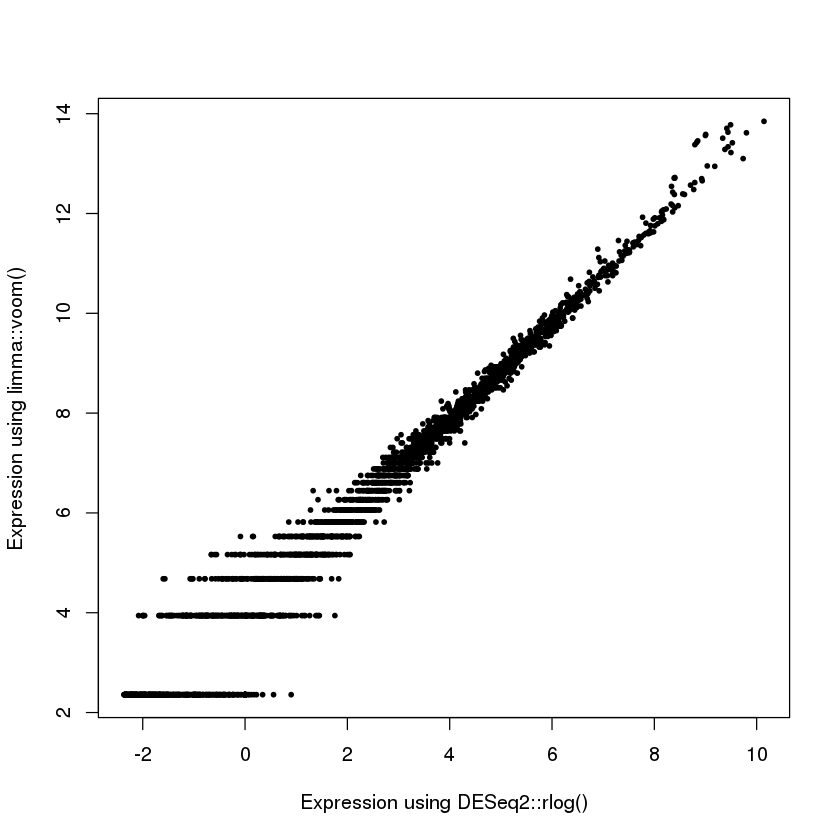

In [41]:
plot(rldexp[,1],vmexp[,1],pch=19,cex=0.5,xlab="Expression using DESeq2::rlog()",ylab="Expression using limma::voom()")

# Use ggplot for illustration

In [42]:
library(ggplot2)

In [55]:
makedat<-function(expdat,pdata,geneid,psampid){
    expid<-colnames(expdat)
    x<-as.numeric(expdat[geneid,])
    myexp<-data.frame(expid=expid,x=x)
    merge(pdata,myexp,by.x=psampid,by.y="expid",all=TRUE)
}
makedat(vmexp,phdata0,"USA300HOU_0001","sampleid")

sampleid          fname             trt  ph bio_rep
1     1-alpha-vehicle control-pH6    1Aalpha.csv vehicle control pH6       1
2               10-beta-DU011-pH7    10Dbeta.csv           DU011 pH7       2
3     11-beta-vehicle control-pH7    11Bbeta.csv vehicle control pH7       3
4     13-beta-vehicle control-pH6    13Abeta.csv vehicle control pH6       3
5              15-gamma-DU011-pH6   15Cgamma.csv           DU011 pH6       3
6              16-gamma-DU011-pH7   16Dgamma.csv           DU011 pH7       3
7              18-gamma-DU011-pH6   18Cgamma.csv           DU011 pH6       1
8    19-gamma-vehicle control-pH6   19Agamma.csv vehicle control pH6       1
9     2-alpha-vehicle control-pH7    2Balpha.csv vehicle control pH7       1
10   20-gamma-vehicle control-pH7   20Bgamma.csv vehicle control pH7       1
11             22-delta-DU011-pH7   22Ddelta.csv           DU011 pH7       1
12   24-delta-vehicle control-pH6   24Adelta.csv vehicle control pH6       2
13   25-delta-vehicle control-pH7   25Bdelta.csv vehicle control pH7       2
14             26-delta-DU011-pH6   26Cdelta.csv           DU011 pH6       2
15             27-delta-DU011-pH7   27Ddelta.csv           DU011 pH7       2
16              3-alpha-DU011-pH6    3Calpha.csv           DU011 pH6       1
17 31-epsilon-vehicle control-pH6 31Aepsilon.csv vehicle control pH6       3
18 32-epsilon-vehicle control-pH7 32Bepsilon.csv vehicle control pH7       3
19           33-epsilon-DU011-pH6 33Cepsilon.csv           DU011 pH6       3
20              4-alpha-DU011-pH7    4Dalpha.csv           DU011 pH7       1
21    6-alpha-vehicle control-pH6    6Aalpha.csv vehicle control pH6       2
22     8-beta-vehicle control-pH7     8Bbeta.csv vehicle control pH7       2
23               9-beta-DU011-pH6     9Cbeta.csv           DU011 pH6       2
   tech_rep        x
1         a 9.204166
2         a 8.224209
3         a 8.211876
4         a 8.986567
5         a 9.075752
6         a 7.346510
7         a 9.345743
8         a 9.330840
9         a 8.993438
10        a 8.514285
11        a 8.742161
12        b 9.838894
13        b 8.993401
14        b 8.822115
15        b 8.933998
16        a 8.472761
17        b 9.008764
18        b 7.910641
19        b 8.610768
20        a 8.624997
21        b 9.929209
22        a 8.825118
23        b 8.811331

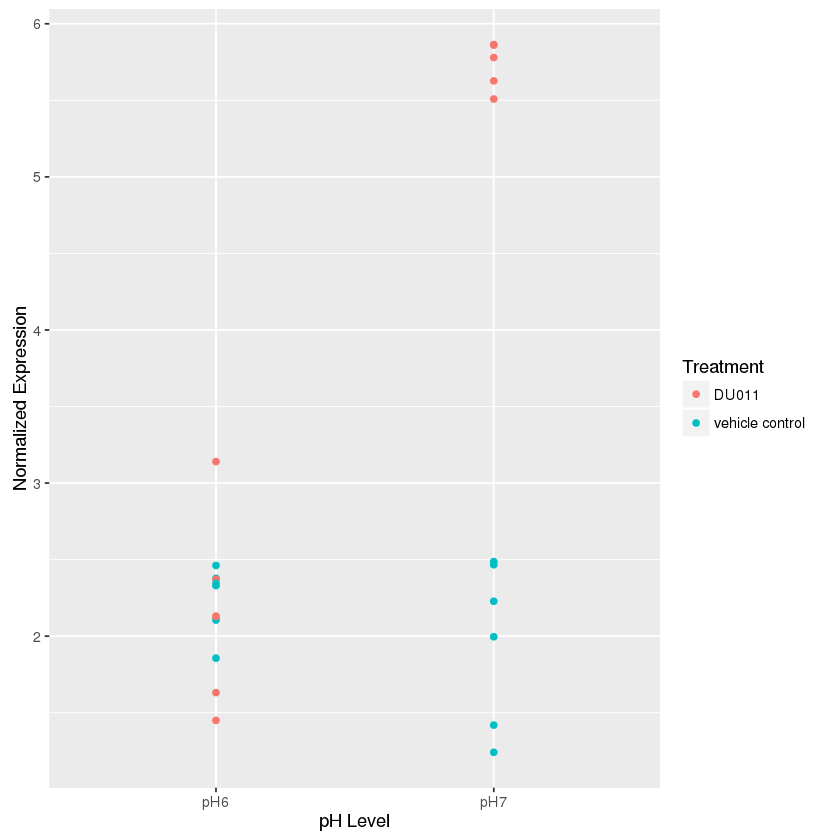

In [66]:
ggplot(makedat(rldexp,phdata0,"USA300HOU_1266","sampleid"),aes(y=x,x=ph,color=trt))+
geom_point()+
labs(y="Normalized Expression",x="pH Level")+
scale_color_discrete(name="Treatment")

In [97]:
library(tidyr)
makedat<-function(expdat,pdata,geneid,psampid){
    geneid<-intersect(geneid,rownames(expdat))
    myexp<-data.frame(t(vmexp[geneid,,drop=FALSE]))
    outwide<-merge(pdata,myexp,by.x=psampid,by.y=0,all=TRUE)
    gather_(outwide,"gene","expression",geneid)
    
}
mydat<-makedat(rldexp,phdata0,c("USA300HOU_1266","USA300HOU_0002","USA300HOU_2346"),"sampleid")

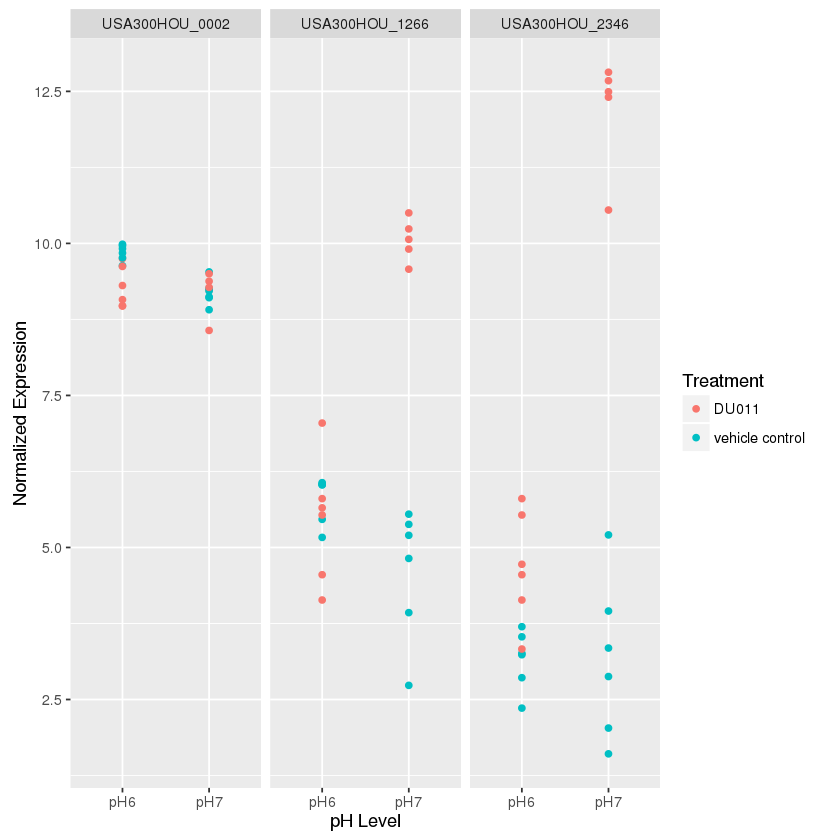

In [106]:
ggplot(mydat,aes(y=expression,x=ph,color=trt))+
geom_point()+
labs(y="Normalized Expression",x="pH Level")+
scale_color_discrete(name="Treatment")+facet_grid(.~gene)

Create the same plot using the lattice package

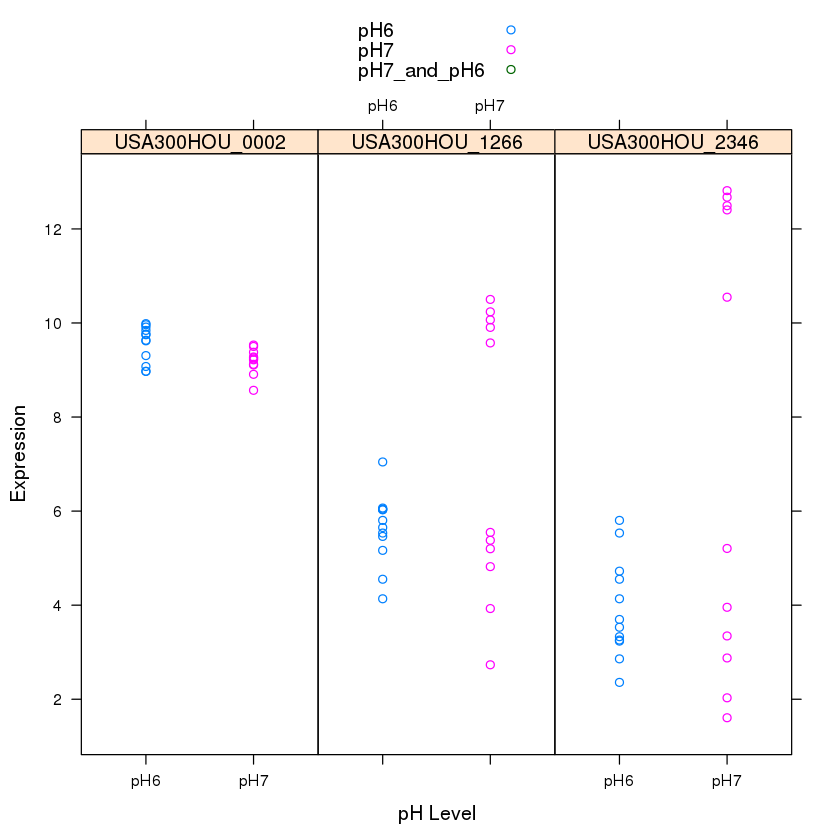

In [102]:
library(lattice)
xyplot(expression~ph|gene,group=ph,data=mydat,
       xlab="pH Level",ylab="Expression",
       auto.key=TRUE,layout=c(3,1))